In [1]:
import ot
import torch
import numpy as np
import matplotlib.pyplot as plt

from functools import partial

In [2]:
from src import (
    em_gmm,
    conditional_em_gmm,
    diag_gmm_log_probs,
    plot_cov_ellipse,
    GMMOTDA
)

In [3]:
n_samples = 100

mean1 = np.array([0., 0.])
cov1 = np.array([[1., 0.5], [0.5, 1.]])
mean2 = np.array([-4., 4.])
cov2 = np.array([[1., 0.5], [0.5, 1.]])

X1 = np.random.multivariate_normal(mean1, cov1, size=n_samples)
X2 = np.random.multivariate_normal(mean2, cov2, size=n_samples)

XP = torch.from_numpy(np.concatenate([X1, X2], axis=0)).float()
YP = torch.from_numpy(np.array([[0, 1],] * len(X1) + [[1, 0],] * len(X2))).float()

In [4]:
A = torch.from_numpy(np.array([[0.75, 0.1], [0.1, 1.]])).float()
b = torch.from_numpy(np.array([6., 7.])).float()

In [5]:
XQ = XP @ A + b
YQ = YP.clone()

In [6]:
x_minima, x_maxima = [], []
y_minima, y_maxima = [], []

x_minima.append(torch.cat([XP, XQ], axis=0)[:, 0].min())
x_maxima.append(torch.cat([XP, XQ], axis=0)[:, 0].max())

y_minima.append(torch.cat([XP, XQ], axis=0)[:, 1].min())
y_maxima.append(torch.cat([XP, XQ], axis=0)[:, 1].max())

xmin, xmax = np.amin(x_minima), np.amax(x_maxima)
ymin, ymax = np.amin(y_minima), np.amax(y_maxima)

print(xmin, xmax, ymin, ymax)

-7.1800137 7.678405 -1.9839181 13.221077


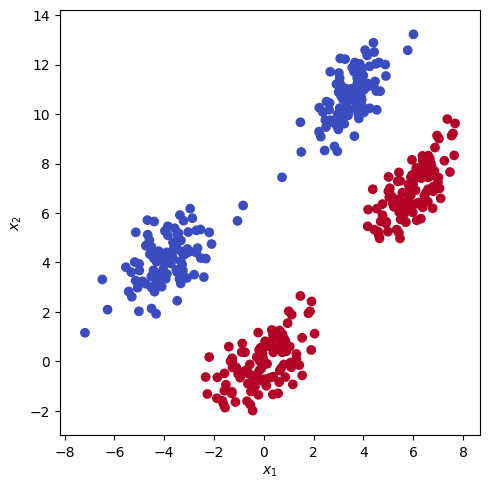

In [7]:
plt.figure(figsize=(5, 5))

plt.scatter(XP[:, 0], XP[:, 1], c=YP[:, 1], cmap=plt.cm.coolwarm)
plt.scatter(XQ[:, 0], XQ[:, 1], c=YQ[:, 1], cmap=plt.cm.coolwarm)

plt.xlim([xmin - 1, xmax + 1])
plt.ylim([ymin - 1, ymax + 1])

plt.xlabel('$x_{1}$')
plt.ylabel('$x_{2}$')

plt.tight_layout()

In [15]:
n_components = 5

clustering_source = partial(
    conditional_em_gmm,
    n_clusters=n_components,
    random_state=42
)

clustering_target = partial(
    em_gmm,
    n_clusters=n_components * 2,
    random_state=42
)

otda = GMMOTDA(
    clustering_source=clustering_source,
    clustering_target=clustering_target,
    ot_solver=ot.emd
)

otda.fit(XP, YP, XQ, YQ)
w, TXP, TYP = otda.transport_samples(
    XP, YP, numel=20)
_TXP, _TYP = otda.rand_transport(XP, YP)

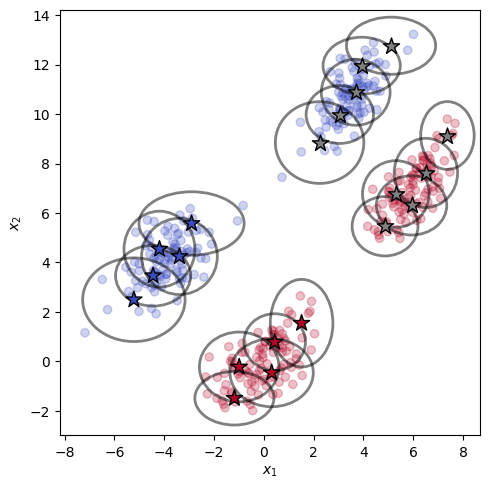

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=XP[:, 0], y=XP[:, 1], c=YP[:, 1], cmap='coolwarm', alpha=0.25, zorder=1)
ax.scatter(otda.centroids_src[:, 0], otda.centroids_src[:, 1], marker='*',
           c=otda.labels_src[:, 1], cmap='coolwarm', edgecolor='k',
           s=150, zorder=5, vmin=0., vmax=1.)
for c, u in zip(otda.centroids_src, otda.stds_src):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax, alpha=0.5, zorder=1)

ax.scatter(x=XQ[:, 0], y=XQ[:, 1], c=YQ[:, 1], cmap='coolwarm', alpha=0.25, zorder=1)
ax.scatter(otda.centroids_tgt[:, 0], otda.centroids_tgt[:, 1], marker='*',
           c='gray', edgecolor='k',
           s=150, zorder=5)
for c, u in zip(otda.centroids_tgt, otda.stds_tgt):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax, alpha=0.5, zorder=1)

ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')

plt.tight_layout()

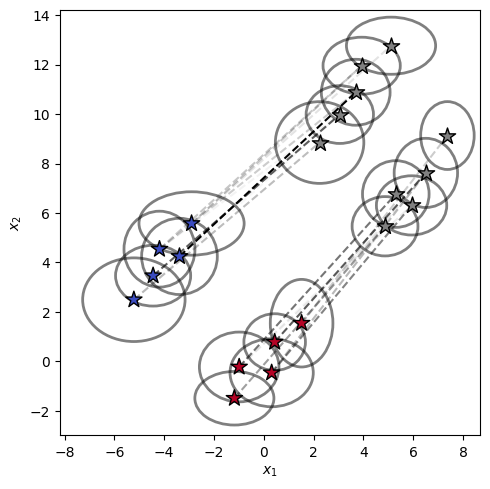

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(otda.centroids_src[:, 0], otda.centroids_src[:, 1], marker='*',
           c=otda.labels_src[:, 1], cmap='coolwarm', edgecolor='k',
           s=150, zorder=5, vmin=0., vmax=1.)
for c, u in zip(otda.centroids_src, otda.stds_src):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax, alpha=0.5, zorder=1)
    
ax.scatter(otda.centroids_tgt[:, 0], otda.centroids_tgt[:, 1], marker='*',
           c='gray', edgecolor='k',
           s=150, zorder=5)
for c, u in zip(otda.centroids_tgt, otda.stds_tgt):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax, alpha=0.5, zorder=1)

ind_i, ind_j = np.where(otda.ot_plan > 0)
for i, j in zip(ind_i, ind_j):
    transparency = (otda.ot_plan[i, j] / otda.ot_plan.numpy().max()).item()
    plt.plot([otda.centroids_src[i, 0], otda.centroids_tgt[j, 0]],
             [otda.centroids_src[i, 1], otda.centroids_tgt[j, 1]], 'k--',
             zorder=1, alpha=transparency)

ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')

plt.tight_layout()

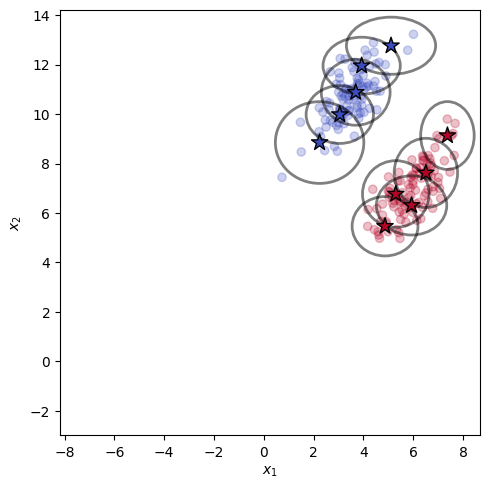

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=XQ[:, 0], y=XQ[:, 1], c=YQ[:, 1], cmap='coolwarm', alpha=0.25, zorder=1)
ax.scatter(otda.centroids_tgt[:, 0], otda.centroids_tgt[:, 1], marker='*',
           c=otda.estimated_labels_tgt[:, 1], cmap='coolwarm', edgecolor='k',
           s=150, zorder=5, vmin=0., vmax=1.)
for c, u in zip(otda.centroids_tgt, otda.stds_tgt):
    plot_cov_ellipse(pos=c, cov=np.diag(u), ax=ax, alpha=0.5, zorder=1)
    
ax.set_xlim([xmin - 1, xmax + 1])
ax.set_ylim([ymin - 1, ymax + 1])

ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')

plt.tight_layout()

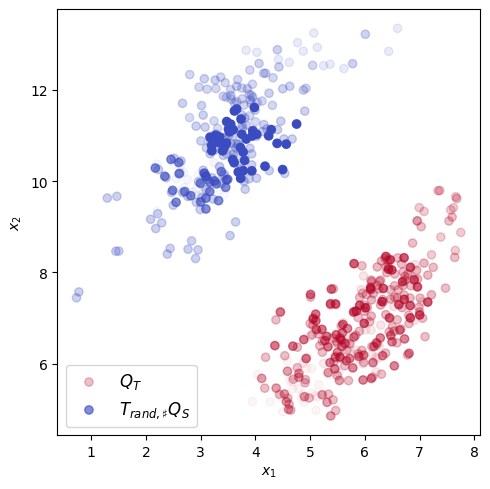

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=XQ[:, 0], y=XQ[:, 1], c=YQ[:, 1], cmap='coolwarm', alpha=0.25, zorder=1,
           label=r"$Q_{T}$")
ax.scatter(x=TXP[:, 0], y=TXP[:, 1], c=TYP[:, 1], cmap='coolwarm', alpha=(w / w.max()), zorder=1,
           label=r"$T_{rand,\sharp}Q_{S}$")

ax.legend(fontsize=12)

ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')

plt.tight_layout()

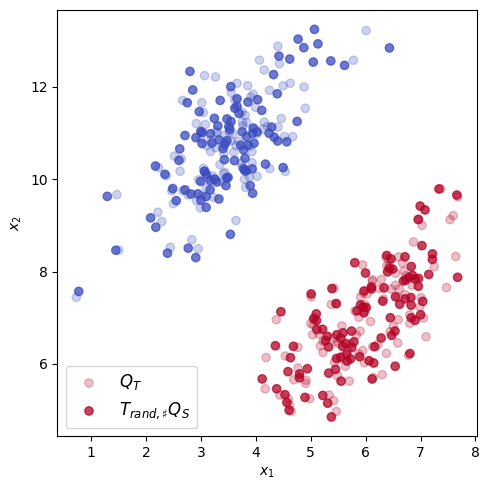

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

ax.scatter(x=XQ[:, 0], y=XQ[:, 1], c=YQ[:, 1], cmap='coolwarm', alpha=0.25, zorder=1,
           label=r"$Q_{T}$")
ax.scatter(x=_TXP[:, 0], y=_TXP[:, 1], c=_TYP[:, 1], cmap='coolwarm', alpha=0.75, zorder=1,
           label=r"$T_{rand,\sharp}Q_{S}$")

ax.legend(fontsize=12)

ax.set_xlabel('$x_{1}$')
ax.set_ylabel('$x_{2}$')

plt.tight_layout()